Vamos a meter el nivel de torneo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from ranking_scores import puntos_ranking
from sklearn.preprocessing import StandardScaler

In [2]:
def calculate_head_to_head_partido(jugador1, jugador2, dataset):
    h2h = 0.5
    new_data = dataset[((dataset['winner_id'] == jugador1) | (dataset['loser_id'] == jugador1)) &
                    ((dataset['winner_id'] == jugador2) | (dataset['loser_id'] == jugador2))]
    if len(new_data) > 0:
            h2h = (new_data['winner_id'] == jugador1).sum() / len(new_data)
    return h2h

In [3]:
def calculate_head_to_head(dataset):
    dataset['fecha_partido'] = pd.to_datetime(dataset['tourney_date'], format='%Y%m%d')
    # Crea una nueva columna 'head_to_head' con un valor inicial de 0.5
    dataset['head_to_head'] = 0.5
    
    # Itera sobre cada fila del conjunto de datos
    for i in range(len(dataset)):
        jugador1 = dataset.iloc[i]['winner_id']
        jugador2 = dataset.iloc[i]['loser_id']
        fecha = dataset.iloc[i]['fecha_partido']
        new_data = dataset[((dataset['winner_id'] == jugador1) | (dataset['loser_id'] == jugador1)) &
                        ((dataset['winner_id'] == jugador2) | (dataset['loser_id'] == jugador2)) &
                        (dataset['fecha_partido'] < fecha)]
        if len(new_data) > 0:
            partidos_ganados = len(new_data[new_data['winner_id'] == jugador1])
            h2h = partidos_ganados / len(new_data)
            dataset.at[i, 'head_to_head'] = h2h
    
    return dataset



In [4]:
# Cargar los datos de los años
data_2021 = pd.read_csv('atp_matches_2021.csv')
data_2021_qc = pd.read_csv('atp_matches_qual_chall_2021.csv')
data_2022 = pd.read_csv('atp_matches_2022.csv')
data_2022_qc = pd.read_csv('atp_matches_qual_chall_2022.csv')
data_2023 = pd.read_csv('atp_matches_2023.csv')
data_2023_qc = pd.read_csv('atp_matches_qual_chall_2023.csv')

# Agregar una columna 'source' a cada DataFrame
data_2021['source'] = 'atp_matches_2021.csv'
data_2021_qc['source'] = 'atp_matches_qual_chall_2021.csv'
data_2022['source'] = 'atp_matches_2022.csv'
data_2022_qc['source'] = 'atp_matches_qual_chall_2022.csv'
data_2023['source'] = 'atp_matches_2023.csv'
data_2023_qc['source'] = 'atp_matches_qual_chall_2023.csv'

# Combinar los datos en un solo DataFrame
data_all = pd.concat([data_2021, data_2021_qc, data_2022, data_2022_qc, data_2023, data_2023_qc])
data_all = data_all.reset_index(drop=False)
# Aplicar la función calculate_head_to_head
data_all = calculate_head_to_head(data_all)

In [5]:
# Filtrar los datos para obtener solo los partidos de 2023 del archivo 'atp_matches_2023.csv'
dataset = data_all[(data_all['source'] == 'atp_matches_2023.csv') | (data_all['source'] == 'atp_matches_qual_chall_2023.csv')]

In [6]:
tenistas = pd.concat([dataset['winner_id'], dataset['loser_id']])
tenistas = set(tenistas)
num_tenistas = len(tenistas)

In [7]:
dataset_r = pd.read_csv('atp_rankings_20s.csv')

### Realizamos el tratamiento de los NaN's antes de nada

In [8]:
# Encontramos el valor más común entre 'Grass', 'Hard', y 'Clay'
most_common = dataset[dataset['surface'].isin(['Grass', 'Hard', 'Clay'])]['surface'].mode()[0]

# Reemplazamos los valores que no son 'Grass', 'Hard', o 'Clay' (los NaN's) con el valor más común
dataset.loc[~dataset['surface'].isin(['Grass', 'Hard', 'Clay']), 'surface'] = most_common

In [9]:
pk = puntos_ranking(dataset, dataset_r, 2023)

c:\Users\Guille\OneDrive\Escritorio\Deepty Projects\tenis_project\ranking_scores.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['tourney_date'] = pd.to_datetime(dataset['tourney_date'], format='%Y%m%d')
c:\Users\Guille\OneDrive\Escritorio\Deepty Projects\tenis_project\ranking_scores.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['year_month'] = dataset['tourney_date'].dt.to_period('M')


In [10]:
dataset.loc[:, 'winner_rank_points'], dataset.loc[:, 'loser_rank_points'] = pk['winner_points'], pk['loser_points']

C:\Users\Guille\AppData\Local\Temp\ipykernel_45872\3391766934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:, 'winner_rank_points'], dataset.loc[:, 'loser_rank_points'] = pk['winner_points'], pk['loser_points']


In [11]:
dataset.head()

,index,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,...,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,source,fecha_partido,head_to_head,year_month
23114,0,2023-9900,United Cup,Hard,18,A,2023-01-02,300,126203,3.0,...,9.0,9.0,9.0,3355,16.0,2375,atp_matches_2023.csv,2023-01-02,1.0,2023-01
23115,1,2023-9900,United Cup,Hard,18,A,2023-01-02,299,126207,NaN,...,1.0,3.0,19.0,2000,23.0,1865,atp_matches_2023.csv,2023-01-02,0.0,2023-01
23116,2,2023-9900,United Cup,Hard,18,A,2023-01-02,296,126203,3.0,...,2.0,2.0,9.0,3355,10.0,2905,atp_matches_2023.csv,2023-01-02,0.5,2023-01
23117,3,2023-9900,United Cup,Hard,18,A,2023-01-02,295,126207,NaN,...,6.0,9.0,19.0,2000,245.0,220,atp_matches_2023.csv,2023-01-02,0.5,2023-01
23118,4,2023-9900,United Cup,Hard,18,A,2023-01-02,292,126774,1.0,...,1.0,2.0,4.0,5550,16.0,2375,atp_matches_2023.csv,2023-01-02,1.0,2023-01


In [12]:
dataset

,index,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,...,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,source,fecha_partido,head_to_head,year_month
23114,0,2023-9900,United Cup,Hard,18,A,2023-01-02,300,126203,3.0,...,9.0,9.0,9.0,3355,16.0,2375,atp_matches_2023.csv,2023-01-02,1.0,2023-01
23115,1,2023-9900,United Cup,Hard,18,A,2023-01-02,299,126207,NaN,...,1.0,3.0,19.0,2000,23.0,1865,atp_matches_2023.csv,2023-01-02,0.0,2023-01
23116,2,2023-9900,United Cup,Hard,18,A,2023-01-02,296,126203,3.0,...,2.0,2.0,9.0,3355,10.0,2905,atp_matches_2023.csv,2023-01-02,0.5,2023-01
23117,3,2023-9900,United Cup,Hard,18,A,2023-01-02,295,126207,NaN,...,6.0,9.0,19.0,2000,245.0,220,atp_matches_2023.csv,2023-01-02,0.5,2023-01
23118,4,2023-9900,United Cup,Hard,18,A,2023-01-02,292,126774,1.0,...,1.0,2.0,4.0,5550,16.0,2375,atp_matches_2023.csv,2023-01-02,1.0,2023-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36758,10658,2023-8268,Yokkaichi CH,Hard,32,C,2023-11-27,241,211346,9.0,...,2.0,4.0,514.0,35,1845.0,1,atp_matches_qual_chall_2023.csv,2023-11-27,0.5,2023-11
36759,10659,2023-8268,Yokkaichi CH,Hard,32,C,2023-11-27,240,126208,5.0,...,3.0,7.0,454.0,89,920.0,16,atp_matches_qual_chall_2023.csv,2023-11-27,0.5,2023-11
36760,10660,2023-8268,Yokkaichi CH,Hard,32,C,2023-11-27,239,200661,7.0,...,7.0,11.0,550.0,72,929.0,16,atp_matches_qual_chall_2023.csv,2023-11-27,0.5,2023-11
36761,10661,2023-8268,Yokkaichi CH,Hard,32,C,2023-11-27,238,132054,6.0,...,7.0,10.0,491.0,82,1048.0,10,atp_matches_qual_chall_2023.csv,2023-11-27,0.5,2023-11


In [13]:
'''Indice 7: ganador del partido.
Indice 15: perdedor del partido.
Indice -1: puntos en el ranking del jugador ganador
Indice -3: puntos en el ranking del jugador perdedor
Indice 2: tipo de campo del partido (grass, hard o clay)'''
'''X = dataset.iloc[:, [7, 15, -1, -3, 2]].values
y = dataset.iloc[:, 7].values'''

'X = dataset.iloc[:, [7, 15, -1, -3, 2]].values\ny = dataset.iloc[:, 7].values'

In [14]:
columnas_X = ['winner_id', 'loser_id', 'winner_rank_points', 'loser_rank_points', 'head_to_head', 'tourney_level', 'surface']
columna_y = 'winner_id'
X = dataset[columnas_X].values
y = dataset[columna_y].values


In [15]:
X[:, 0] = X[:, 0].astype(str)
X[:, 1] = X[:, 1].astype(str)
y = y.astype(str)

In [16]:
X[:, [0, 1]]

array([['126203', '126610'],
       ['126207', '207518'],
       ['126203', '128034'],
       ...,
       ['200661', '207606'],
       ['132054', '124074'],
       ['208389', '211628']], dtype=object)

In [17]:
# Crear el codificador
encoder = OneHotEncoder(sparse_output=False)

# Ajustar el codificador con los datos de ambos jugadores y 'y'
encoder.fit(X[:, [0, 1]].reshape(-1, 1))

# Transformar las columnas de los jugadores
player1_onehot = encoder.transform(X[:, 0].reshape(-1, 1))
player2_onehot = encoder.transform(X[:, 1].reshape(-1, 1))

# Transformar el vector objetivo 'y' con el mismo codificador 'X'
y = encoder.transform(y.reshape(-1, 1))

# Concatenar las columnas one-hot con el resto de tus datos
X = np.concatenate([player1_onehot, player2_onehot, X[:, 2:]], axis=1)


In [18]:
# Matriz de booleanos aleatorios del mismo tamaño que tus datos
swap = np.random.rand(len(X)) > 0.5

# Intercambiamos las posiciones de los jugadores en 'X' donde 'swap' es True
X[swap, :num_tenistas], X[swap, num_tenistas:num_tenistas*2] = X[swap, num_tenistas:num_tenistas*2], X[swap, :num_tenistas].copy()

# Intercambiamos las posiciones de los puntos en el ranking donde 'swap' es True
X[swap, num_tenistas*2], X[swap, num_tenistas*2+1] = X[swap, num_tenistas*2+1], X[swap, num_tenistas*2].copy()

mask = (swap) & (X[:, -3] != -1)
X[mask, -3] = 1 - X[mask, -3]

In [19]:
# Concatenar las columnas -5 y -4
columnas_concatenadas = np.concatenate((X[:, -5].reshape(-1, 1), X[:, -4].reshape(-1, 1)), axis=1)

# Convertir el array de dos dimensiones en uno de una dimensión
columna_unica = np.ravel(columnas_concatenadas)
print(columna_unica)
# Crear el escalador
scaler = StandardScaler()

# Entrenar el escalador con el vector de las columnas concatenadas
scaler.fit(columna_unica.reshape(-1, 1))

X[:, [-5]] = scaler.transform(X[:, [-5]])
X[:, [-4]] = scaler.transform(X[:, [-4]])

[2375 3355 1865 ... 82 65 23]


In [20]:
# Crear el escalador de h2h
scaler2 = StandardScaler()

# Entrenar el escalador con el vector de las columnas concatenadas
scaler2.fit(X[:, [num_tenistas*2+2]])

X[:, [num_tenistas*2+2]] = scaler2.transform(X[:, [num_tenistas*2+2]])

In [21]:
# Esto es para el tipo de campo
# Crear el codificador
encoder2 = OneHotEncoder(sparse_output=False)

# Ajustar y transformar la columna del tipo de campo
field_type_onehot = encoder2.fit_transform(X[:, num_tenistas*2+4].reshape(-1, 1))

# Concatenar la columna one-hot con el resto de los datos
X = np.concatenate([X[:, :num_tenistas*2+4], field_type_onehot], axis=1)

In [22]:
# Esto es para el nivel del torneo
# Crear el codificador
encoder3 = OneHotEncoder(sparse_output=False)

# Ajustar y transformar la columna del tipo de campo
tourney_level_onehot = encoder3.fit_transform(X[:, num_tenistas*2+3].reshape(-1, 1))

# Concatenar la columna one-hot con el resto de los datos
X = np.concatenate([X[:, :num_tenistas*2+3], tourney_level_onehot, X[:, num_tenistas*2+4:]], axis=1)

In [23]:
# Dividir en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
X_train = X_train.astype('float64')
y_train = y_train.astype('float64')

In [ ]:
# Vamos a inferir la media poblacional a partir de una muestra aleatoria simple con n = 30
muestras = [0 for _ in range(300)]
partidos = [0 for _ in range(300)]
for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train = X_train.astype('float64')
    y_train = y_train.astype('float64')
    # Definimos el modelo
    model = Sequential()

    # Añadir la capa de entrada y la primera capa oculta
    model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.2))
    # Añadir la segunda capa oculta
    # model.add(Dense(units=32, activation='tanh'))

    # Añadir la capa de salida
    model.add(Dense(units=y.shape[1], activation='softmax'))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    model.fit(X_train, y_train, epochs=15, batch_size=32)

    X_test = X_test.astype('float64')
    y_test = y_test.astype('float64')

    # Hacemos la predicción
    prediccion_test = model.predict(X_test)

    # Obtenemos los índices donde hay un 1 en las primeras 440 columnas y en las siguientes 440 columnas
    indices_1 = np.where(X_test[:, :num_tenistas] == 1)[1]
    indices_2 = np.where(X_test[:, num_tenistas:num_tenistas*2] == 1)[1]

    # Obtenemos las predicciones para los índices obtenidos
    predicciones_1 = prediccion_test[np.arange(len(prediccion_test)), indices_1]
    predicciones_2 = prediccion_test[np.arange(len(prediccion_test)), indices_2]

    # Encontramos el índice del máximo para cada fila
    max_indices = np.where(predicciones_1 > predicciones_2, indices_1, indices_2)

    # Convertimos max_indices en un array 2D
    max_indices_2D = np.eye(encoder.categories_[0].shape[0])[max_indices]

    # Usamos el codificador para transformar los índices a sus etiquetas originales
    etiquetas_predichas = encoder.inverse_transform(max_indices_2D)
    etiqueta_y_test = encoder.inverse_transform(y_test)
    # Obtenemos los jugadores en el partido
    jugadores_en_partido_1 = X_test[:, :num_tenistas]
    jugadores_en_partido_2 = X_test[:, num_tenistas:num_tenistas*2]

    # Usamos el codificador para transformar los jugadores en el partido a sus etiquetas originales
    etiquetas_jugadores_en_partido_1 = encoder.inverse_transform(jugadores_en_partido_1)
    etiquetas_jugadores_en_partido_2 = encoder.inverse_transform(jugadores_en_partido_2)

    # Creamos una matriz donde cada fila es un partido y contiene los dos jugadores de ese partido
    matriz_partidos = np.column_stack((etiquetas_jugadores_en_partido_1, etiquetas_jugadores_en_partido_2))
    # Hacemos la predicción de las probabilidades
    probabilidades_test = model.predict(X_test)

    # Creamos una matriz vacía para almacenar las probabilidades finales
    probabilidades_finales = np.zeros((len(probabilidades_test), 2))

    # Asignamos las probabilidades a los jugadores correspondientes
    probabilidades_finales[:, 0] = probabilidades_test[np.arange(len(probabilidades_test)), indices_1]
    probabilidades_finales[:, 1] = probabilidades_test[np.arange(len(probabilidades_test)), indices_2]
    # Recorremos la matriz de probabilidades
    for j in range(len(probabilidades_finales)):
        # Comprobamos si una de las probabilidades es al menos el doble que la otra
        if probabilidades_finales[j, 0] < 10000 * probabilidades_finales[j, 1] and probabilidades_finales[j, 1] < 10000 * probabilidades_finales[j, 0]:
            # Si ninguna de las probabilidades es al menos el doble que la otra, establecemos la lista a [-1]
            probabilidades_finales[j] = -1
    ganadores = [-1 for _ in range(len(probabilidades_finales))]
    for j in range(len(probabilidades_finales)):
        if probabilidades_finales[j][0] != -1:
            ganadores[j] = 0 if probabilidades_finales[j][0] > probabilidades_finales[j][1] else 1
        else:
            ganadores[j] = -1
    aciertos = 0
    total = 0
    for j in range(len(ganadores)):
        if ganadores[j] != -1:
            if matriz_partidos[j][ganadores[j]] == etiqueta_y_test[j][0]:
                aciertos += 1
            total += 1
    precision = aciertos / total*100
    muestras[i] = precision
    partidos[i] = total / len(etiqueta_y_test)*100
    print(precision, total / len(etiqueta_y_test)*100)

Epoch 1/15
342/342 [==============================] - 2s 4ms/step - loss: 6.3742 - accuracy: 0.0153
Epoch 2/15
342/342 [==============================] - 1s 3ms/step - loss: 5.5099 - accuracy: 0.0714
Epoch 3/15
342/342 [==============================] - 1s 3ms/step - loss: 4.9472 - accuracy: 0.1935
Epoch 4/15
342/342 [==============================] - 1s 3ms/step - loss: 4.2382 - accuracy: 0.4077
Epoch 5/15
342/342 [==============================] - 1s 3ms/step - loss: 3.3900 - accuracy: 0.5468
Epoch 6/15
342/342 [==============================] - 1s 3ms/step - loss: 2.5922 - accuracy: 0.6322
Epoch 7/15
342/342 [==============================] - 1s 3ms/step - loss: 1.9831 - accuracy: 0.6803
Epoch 8/15
342/342 [==============================] - 1s 3ms/step - loss: 1.5508 - accuracy: 0.7285
Epoch 9/15
342/342 [==============================] - 1s 4ms/step - loss: 1.2350 - accuracy: 0.7689
Epoch 10/15
342/342 [==============================] - 1s 4ms/step - loss: 1.0022 - accuracy: 0.8012

c:\Users\Guille\anaconda3\envs\optim-2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


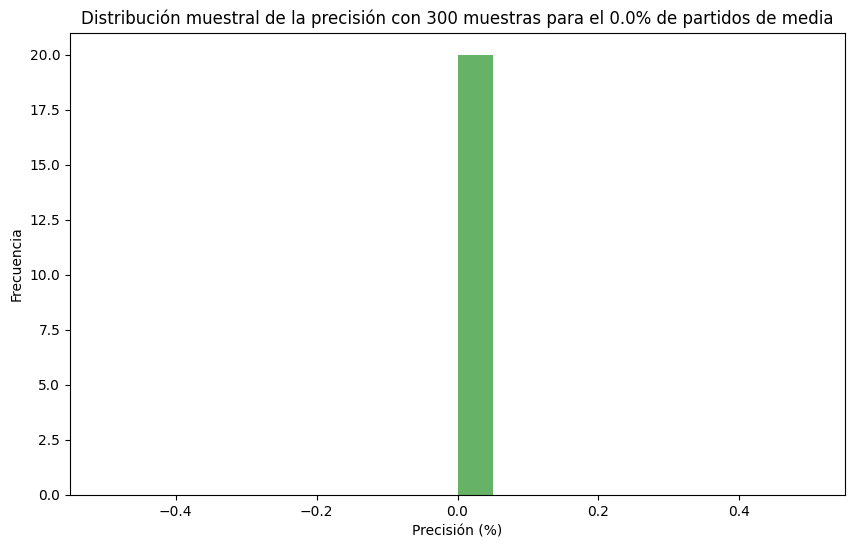

0.0 0.0 0.0


In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Calcular la media y la desviación estándar de las muestras
mu, std = np.mean(muestras), np.std(muestras)

# Generar la distribución gaussiana
gaussian = norm(loc=mu, scale=std)

# Crear un array de valores x para la gráfica
x = np.linspace(min(muestras), max(muestras), 100)

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.hist(muestras, bins=20, density=True, alpha=0.6, color='g')
plt.plot(x, gaussian.pdf(x), 'r', linewidth=2)
plt.xlabel('Precisión (%)')
plt.ylabel('Frecuencia')
plt.title(f'Distribución muestral de la precisión con 300 muestras para el {np.round(np.mean(partidos), 2)}% de partidos de media')
plt.show()
print(mu, std, np.median(muestras))

In [ ]:
# Definimos el modelo
from keras.layers import Dense, Input
model = Sequential()

# Añadir la capa de entrada
model.add(Input(shape=(X_train.shape[1],)))

# Añadir la primera capa oculta
model.add(Dense(units=64, activation='relu'))

# Añadir la capa de salida
model.add(Dense(units=y.shape[1], activation='softmax'))

# Compilar el modelo
model.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=9, batch_size=32)


Epoch 1/9
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0118 - loss: 6.7969
Epoch 2/9
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0542 - loss: 5.6315
Epoch 3/9
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1688 - loss: 5.0852
Epoch 4/9
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3770 - loss: 4.4118
Epoch 5/9
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5368 - loss: 3.5600
Epoch 6/9
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6289 - loss: 2.7235
Epoch 7/9
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6813 - loss: 2.0850
Epoch 8/9
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7346 - loss: 1.6071
Epoch 9/9
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7780 - loss: 1.2581


In [ ]:
X_test = X_test.astype('float64')
y_test = y_test.astype('float64')

In [ ]:
# Hacemos la predicción
prediccion_test = model.predict(X_test)

# Obtenemos los índices donde hay un 1 en las primeras 440 columnas y en las siguientes 440 columnas
indices_1 = np.where(X_test[:, :num_tenistas] == 1)[1]
indices_2 = np.where(X_test[:, num_tenistas:num_tenistas*2] == 1)[1]

# Obtenemos las predicciones para los índices obtenidos
predicciones_1 = prediccion_test[np.arange(len(prediccion_test)), indices_1]
predicciones_2 = prediccion_test[np.arange(len(prediccion_test)), indices_2]

# Encontramos el índice del máximo para cada fila
max_indices = np.where(predicciones_1 > predicciones_2, indices_1, indices_2)

# Convertimos max_indices en un array 2D
max_indices_2D = np.eye(encoder.categories_[0].shape[0])[max_indices]

# Usamos el codificador para transformar los índices a sus etiquetas originales
etiquetas_predichas = encoder.inverse_transform(max_indices_2D)

print(etiquetas_predichas)

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[['106310']
 ['105575']
 ['134457']
 ...
 ['105077']
 ['136440']
 ['202104']]


In [ ]:
# Usamos el codificador para transformar las etiquetas codificadas a sus etiquetas originales
etiqueta_y_test = encoder.inverse_transform(y_test)

print(etiqueta_y_test)

[['106186']
 ['105575']
 ['134457']
 ...
 ['105077']
 ['136440']
 ['202104']]


In [ ]:
print(f"Precisión del test: {np.round(np.sum(etiqueta_y_test == etiquetas_predichas) / len(etiquetas_predichas)*100, 2)}%")

Precisión del test: 63.99%


In [ ]:
# Obtenemos los jugadores en el partido
jugadores_en_partido_1 = X_test[:, :num_tenistas]
jugadores_en_partido_2 = X_test[:, num_tenistas:num_tenistas*2]

# Usamos el codificador para transformar los jugadores en el partido a sus etiquetas originales
etiquetas_jugadores_en_partido_1 = encoder.inverse_transform(jugadores_en_partido_1)
etiquetas_jugadores_en_partido_2 = encoder.inverse_transform(jugadores_en_partido_2)

# Creamos una matriz donde cada fila es un partido y contiene los dos jugadores de ese partido
matriz_partidos = np.column_stack((etiquetas_jugadores_en_partido_1, etiquetas_jugadores_en_partido_2))

print(matriz_partidos)


[['106186' '106310']
 ['145001' '105575']
 ['134457' '207799']
 ...
 ['200611' '105077']
 ['144918' '136440']
 ['202104' '106198']]


In [ ]:
# Hacemos la predicción de las probabilidades
probabilidades_test = model.predict(X_test)

# Creamos una matriz vacía para almacenar las probabilidades finales
probabilidades_finales = np.zeros((len(probabilidades_test), 2))

# Asignamos las probabilidades a los jugadores correspondientes
probabilidades_finales[:, 0] = probabilidades_test[np.arange(len(probabilidades_test)), indices_1]
probabilidades_finales[:, 1] = probabilidades_test[np.arange(len(probabilidades_test)), indices_2]

print(probabilidades_finales)

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[0.09085249 0.45476875]
 [0.08875676 0.62081105]
 [0.38269421 0.01254666]
 ...
 [0.00215182 0.37518385]
 [0.07555158 0.61192131]
 [0.64219075 0.25289309]]


In [ ]:
# Recorremos la matriz de probabilidades
for i in range(len(probabilidades_finales)):
    # Comprobamos si una de las probabilidades es al menos el doble que la otra
    if probabilidades_finales[i, 0] < 2.8836553 * probabilidades_finales[i, 1] and probabilidades_finales[i, 1] < 2.8836553 * probabilidades_finales[i, 0]:
        # Si ninguna de las probabilidades es al menos el doble que la otra, establecemos la lista a [-1]
        probabilidades_finales[i] = -1

print(probabilidades_finales)

[[ 0.09085249  0.45476875]
 [ 0.08875676  0.62081105]
 [ 0.38269421  0.01254666]
 ...
 [ 0.00215182  0.37518385]
 [ 0.07555158  0.61192131]
 [-1.         -1.        ]]


In [ ]:
ganadores = [-1 for _ in range(len(probabilidades_finales))]
for i in range(len(probabilidades_finales)):
    if probabilidades_finales[i][0] != -1:
        ganadores[i] = 0 if probabilidades_finales[i][0] > probabilidades_finales[i][1] else 1
    else:
        ganadores[i] = -1
print(ganadores)

[1, 1, 0, -1, 0, 0, 0, 0, 1, 0, -1, 1, 0, 1, 1, 1, -1, 1, 0, -1, 1, -1, 1, 1, 0, 1, 1, 0, -1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, -1, 0, -1, -1, 1, 0, 1, 0, 0, 1, 0, 1, 1, -1, 0, 0, 0, 0, 1, -1, 1, 1, -1, 0, 1, -1, 1, -1, 1, 0, -1, 0, 1, -1, -1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, -1, 0, 0, 1, -1, -1, 0, -1, 0, -1, -1, 1, 1, 0, -1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, -1, -1, 1, 0, 1, 0, 1, 1, 0, 1, -1, 0, -1, 1, 0, 0, 1, 0, 1, 0, 1, 0, -1, 1, 0, 1, 0, -1, 0, 1, 0, 1, -1, 1, 0, -1, 0, 1, -1, 0, -1, -1, 0, 0, -1, 1, 1, -1, -1, 1, 1, 0, 1, 1, 0, -1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, -1, 1, 0, 1, -1, -1, 0, 0, 0, 1, 1, -1, -1, -1, -1, 0, 1, 0, 1, 0, 0, 1, -1, 1, 1, 1, -1, -1, 0, 0, -1, 0, 1, 1, 0, 1, 0, -1, 1, 1, 0, 0, -1, 1, 0, 0, 1, 0, 0, -1, 1, 1, 1, 0, -1, 0, 0, -1, 0, 1, -1, -1, 1, 0, 0, 0, 0, 0, -1, 1, -1, -1, 1, 0, 1, -1, 0, 0, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 0, -1, 0, 0, 0, -1, 1, 1, 1, 0, 0, -1, 1, -1, 0, 1, 1, 0, 0, -1, 0, 0, -1, 0, 1, 0, 1, 1, 1, 0, 1, -1, 0, 0, 1, 0, 0, -1

In [ ]:
aciertos = 0
total = 0
for i in range(len(ganadores)):
    if ganadores[i] != -1:
        if matriz_partidos[i][ganadores[i]] == etiqueta_y_test[i][0]:
            aciertos += 1
        total += 1
print(f'La precisión es de {np.round(aciertos/total, 2)*100}% para el {np.round(total/len(etiqueta_y_test), 2)*100}% de los partidos del test')

La precisión es de 68.0% para el 74.0% de los partidos del test


In [ ]:
from urllib.request import urlretrieve

In [ ]:
from datetime import datetime

In [ ]:
def predecir_partido(nombre_jugador1, apellido_jugador1, nombre_jugador2, apellido_jugador2, torneo=None, superficie=None):
    """
    Predice el resultado de un partido entre dos jugadores.

    Parámetros:
    - nombre_jugador1 (str): Nombre del primer jugador.
    - apellido_jugador1 (str): Apellido del primer jugador.
    - nombre_jugador2 (str): Nombre del segundo jugador.
    - apellido_jugador2 (str): Apellido del segundo jugador.

    Retorna:
    - str: El resultado del partido (por ejemplo, "Gana Jugador 1" o "Empate").
    """

    # Cargar los datos de jugadores y rankings
    jugadores = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_players.csv')
    current_rankings = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_rankings_current.csv')

    # Filtrar información del primer jugador
    jugador1 = jugadores[(jugadores['name_first'] == nombre_jugador1) & (jugadores['name_last'] == apellido_jugador1)]
    player_id1 = jugador1['player_id'].values[0] if not jugador1.empty else 0

    if player_id1 == 0:
        return 'Jugador 1 no encontrado'
    try:
        player_id1_encoder = encoder.transform([[str(player_id1)]])
    except:
        return f'El jugador {nombre_jugador1} {apellido_jugador1} no está disponible en el modelo'
    # Filtrar información del segundo jugador
    jugador2 = jugadores[(jugadores['name_first'] == nombre_jugador2) & (jugadores['name_last'] == apellido_jugador2)]
    player_id2 = jugador2['player_id'].values[0] if not jugador2.empty else 0
    if player_id2 == 0:
        return 'Jugador 2 no encontrado'
    try:
        player_id2_encoder = encoder.transform([[str(player_id2)]])
    except:
        return f'El jugador {nombre_jugador2} {apellido_jugador2} no está disponible en el modelo'
    # Obtener los puntos de los jugadores en la fecha más reciente
    puntos_jugador1 = current_rankings[current_rankings['player'] == player_id1]['points'].max()
    if pd.isnull(puntos_jugador1):
        puntos_jugador1 = 0
    puntos_jugador1_scaler = scaler.transform([[puntos_jugador1]])
    puntos_jugador2 = current_rankings[current_rankings['player'] == player_id2]['points'].max()
    if pd.isnull(puntos_jugador2):
        puntos_jugador2 = 0
    puntos_jugador2_scaler = scaler.transform([[puntos_jugador2]])
    tipo_torneo = encoder3.transform([[torneo]])
    tipo_campo = encoder2.transform([[superficie]])
    # Cargar los datos de los años
    data_2021 = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2021.csv')
    data_2022 = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2022.csv')
    data_2023 = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2023.csv')

    # Agregar una columna 'source' a cada DataFrame
    data_2021['source'] = 'atp_matches_2021.csv'
    data_2022['source'] = 'atp_matches_2022.csv'
    data_2023['source'] = 'atp_matches_2023.csv'
    # Aplicar la función calculate_head_to_head
    data_all = pd.concat([data_2021, data_2022, data_2023])
    h2h = calculate_head_to_head_partido(player_id1, player_id2, data_all)
    x = np.hstack((player_id1_encoder, player_id2_encoder, puntos_jugador1_scaler, puntos_jugador2_scaler, [[h2h]], tipo_torneo, tipo_campo))
    prediccion = model.predict(x)
    player_id1_encoder[player_id1_encoder==1]
    player_id2_encoder[player_id2_encoder==1]
    indice_1 = np.where(player_id1_encoder == 1)[1]
    indice_2 = np.where(player_id2_encoder == 1)[1]
    return prediccion[0][indice_1][0], prediccion[0][indice_2][0]

In [ ]:
uno, dos = predecir_partido('Maximilian', 'Marterer', 'Lukas', 'Klein', 'M', 'Hard')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [ ]:
uno/dos

2.8836553